## Epstein--Zin Recursive Utility

Given consumption stream $C_t = c(X_t)$, the Epstein--Zin utility time path $\{V_t\}$ is defined recursively by

\begin{equation}
    V_t = \left[ (1-\beta)c^{1-\rho}(X_t) 
        + \beta  
        \left( E_t
           V^{1- \gamma}_{t+1} 
        \right)^{\frac{1-\rho}{1-\gamma}}
          \right]^{\frac{1}{1-\rho}}.
\end{equation}

Let $\theta := (1-\gamma)/(1-\rho)$ and $W_t := V_t^{1-\rho}$.  Then the above becomes

\begin{equation}
    W_t = (1-\beta)c^{1-\rho}(X_t) + \beta  \,
    \left( E_t W^{\theta}_{t+1} 
    \right)^{1/\theta} ,
\end{equation}

or, in functional notation, $w = Tw$ where

\begin{equation}
	Tw(x) =  h(x) +  \beta \,
    \left\{ 
        \int w^{\theta}(y) Q(x, y)
     \right\}^{1/\theta}
\end{equation}

with 
$h(x) := (1-\beta) c^{1-\rho}(x)$.

Here $Q$ is the stochastic kernel for $\{X_t\}$.  In the computations below we assume that

$$ X_{t+1} = a X_t + b + \sigma \xi_{t+1} $$

where $\{\xi_t\}$ is iid and standard normal, and that $c(x) = \exp(x)$.

If we solve for the fixed point $w^*$ of $T$, then we can recover $V_t$ by setting 

$$ v^*(x) := w^*(x)^{1/(1-\rho)} $$

and then $V_t = v^*(X_t)$.

In [1]:
using QuantEcon
using Distributions
using PyPlot

Import functions

In [2]:
include("ez_model.jl")

T

Set up shock draws for Monte Carlo integration.

In [3]:
shock_size = 200     # Number of shock draws in Monte Carlo integral
shocks = randn(shock_size);

Function that plots iterates, starting at $h$.

In [4]:
function compute_limit(ez::EZ, 
                        grid::Vector{Float64}, 
                        init_func::Function, 
                        tol::Float64, 
                        skip::Int64)
        
    println("Computing limit at tolerance $tol\n")
    ρ, γ, β, a, b, σ, θ = ez.ρ, ez.γ, ez.β, ez.a, ez.b, ez.σ, ez.θ
    
    pi_shocks = ez.s_mean + ez.s_std .* shocks 
    
    w = init_func(grid)
    err = tol + 1
    iterate = 1
    while err > tol
        new_w = T(w, ez, grid, shocks)
        f = LinInterp(grid, w)
        g = LinInterp(grid, new_w)
        err = mean( abs((f.(pi_shocks)).^θ - (g.(pi_shocks)).^θ))
        if iterate % skip == 0
            println("error = $err")
        end
        w = new_w
        iterate = iterate + 1
    end
    
    return w
end

compute_limit (generic function with 1 method)

In [5]:
function compute_limit(ez::EZ, grid::Vector{Float64}; tol=1e-10, skip=1)
    
    return compute_limit(ez, grid, ez.h, tol, skip)
end

compute_limit (generic function with 2 methods)

In [6]:
function plot_sequence(ez, grid,n=100)
    
    ρ, γ, β, a, b, σ, θ = ez.ρ, ez.γ, ez.β, ez.a, ez.b, ez.σ, ez.θ

    w = ez.h.(grid) 
    
    fig, ax = subplots(figsize=(9, 6))

    lb = "initial condition"
    jet = ColorMap("jet")
    ax[:plot](grid, w.^(1/(1 - ρ)), color=jet(0), 
            lw=2, alpha=0.6, label=lb)

    for i in 1:n
        w = T(w, ez, grid, shocks)
        ax[:plot](grid, w.^(1/(1 - ρ)), 
            color=jet(i / n), lw=2, alpha=0.6)
    end
    
    show()
end

plot_sequence (generic function with 2 methods)

Now let's build an instance and run the plots.

In [7]:
ez = EZ(γ=4, β=0.9); 

Built EZ instance with θ = -8.823529411764707


In [8]:
grid_min = ez.s_mean - 4 * ez.s_std
grid_max = ez.s_mean + 4 * ez.s_std

grid_size = 250      # Number of grid points

grid = collect(linspace(grid_min, grid_max, grid_size));

Plot stationary distribution.

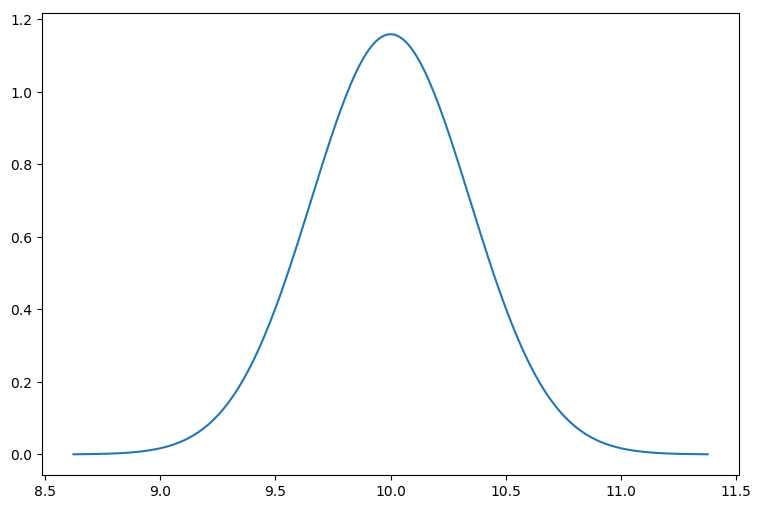

In [9]:
sd = Normal(ez.s_mean, ez.s_std)
fig, ax = subplots(figsize=(9, 6))
ax[:plot](grid, pdf(sd, grid))
show()

In [10]:
w_star = compute_limit(ez, grid);

Computing limit at tolerance 1.0e-10

error = 0.00010371888707111329
error = 3.4673807347223356e-7
error = 1.3901609975338547e-8
error = 1.5230176395669883e-9
error = 2.889589365731271e-10
error = 7.756282953750315e-11


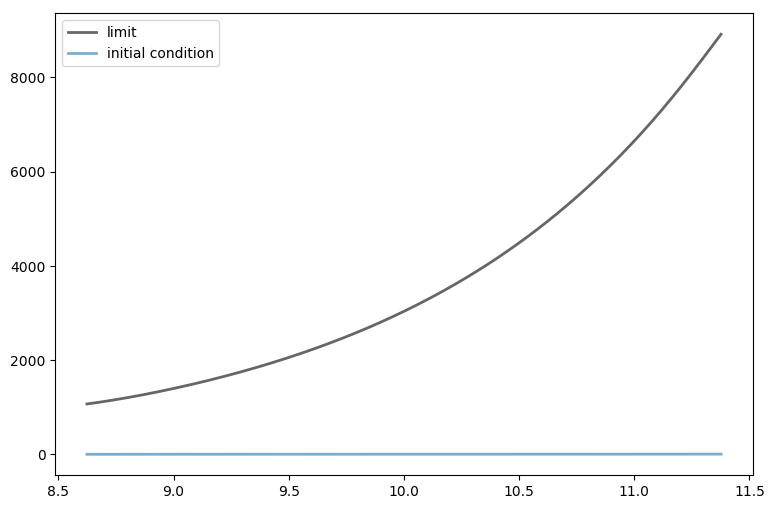

In [11]:
fig, ax = subplots(figsize=(9, 6))
lb = "limit"
ax[:plot](grid, w_star.^(1/(1 - ez.ρ)), color="black", 
        lw=2, alpha=0.6, label=lb)
ax[:plot](grid, ez.h(grid),  
        lw=2, alpha=0.6, label="initial condition")
ax[:legend]()
show()

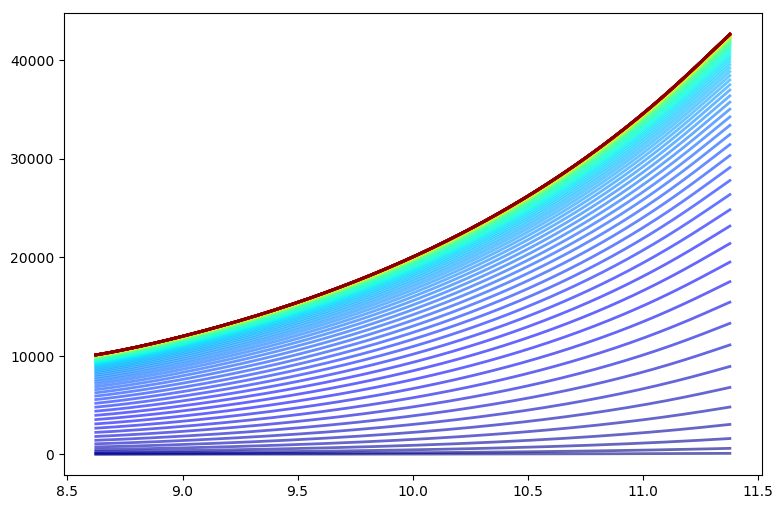

In [12]:
plot_sequence(ez, grid)

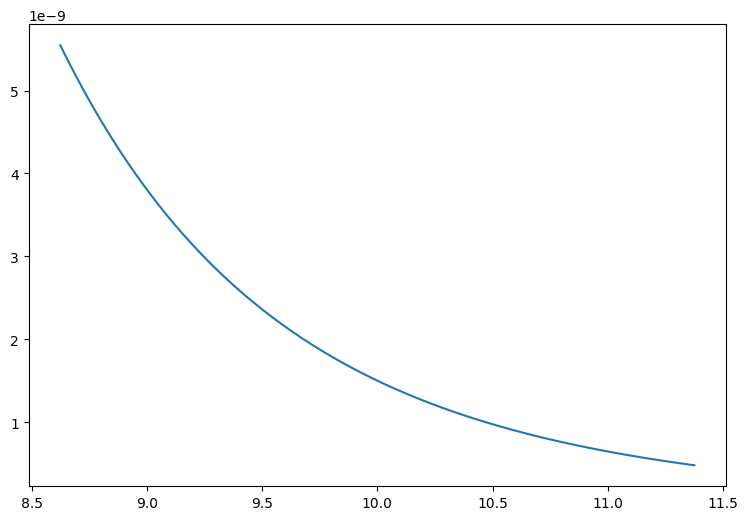

In [13]:
fig, ax = subplots(figsize=(9, 6))
ax[:plot](grid, grid.^ez.θ)
show()